# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Nihal Ezgi Yuceturk",
        'student_2': "Atakan Buyukoglu"}

sciper = {'student_1': 294689, 
          'student_2': 304491}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.random.seed = seed

def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
conversations = getRawDataFromFile()
r1, r2 = np.random.randint(0, len(conversations)-1 , 2)

In [3]:
print(conversations[r1], "\n\n")
print(conversations[r2])


['hello how are you doing today ?', 'i am doing fine about to get ready to go to the gym', 'nice , i am just at amazon , fulfilling orders . i work here .', 'do not forget to exercise every now and again good for', 'thanks for the tip , i forget sometimes . i exercise with my 2 kids though .', 'that is always a plus me and my kids work out all the time', 'you seem to love working out , that is great . i need to make more time', 'yeah it was hard for me at first but i wanted to look better and feel better', 'that makes sense . i am very interested in robotics too .', 'but hey you work at amazon that must be exciting', 'yes , i just like this big company and i like to shop here too .', 'i shop there every chance i get', 'what do you like shopping for ?', 'everything from bedding , outdoors , and sporting goods', 'do you like doing things outdoors like camping ?', 'i love camping and my backyard but not past it'] 


['hi , i just started a new job at an elementary school', 'congrats ! i d

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** 
_Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. (Wikipedia)_ As seen from log-log plot, distribution of our word counts also follows the Zipf's Law. Zipf's Law is a kind of power law distributions where relative change in one variable results the proportional relative change in the other. Log-Log plots helps linearize this power-power relationship due to log function since exponentially related to variables are lineraly related with each other under logarithm function.


**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080 words appears only once in the entire dataset.



In [4]:
# Concatenate lits of list to single list
conlist = [y for x in conversations for y in x] 
# Join the list to a single string
seperator = " "
fullstring = seperator.join(conlist)
# Split each word
wordlist = fullstring.split()

In [5]:
wordlist = " ".join(conlist).split(' ')

In [6]:
# Count Frequency 
def form_dict(wordlist):
    word_dict = {}
    for w in wordlist:
        if(w not in word_dict):
            word_dict[w] = 1
        else :
            word_dict[w] +=1
    return word_dict
word_dict = form_dict(wordlist)

In [7]:
import operator
import collections
#import pandas
sorted_dict = sorted(word_dict.items(), key=operator.itemgetter(1), reverse = True)

['i', '.', 'you', '?', ',', 'a', 'to', 'do', 'is', 'my', 'am', '!', 'the', 'that', 'have', 'are', 'and', 'like', 'it', 'not', 'in', 'what', 'of', 'for', 'how', 'love', 'but', 'good', 'me', 'just', 'so', 'with', 'work', 'your', 'on', 'too', 'at', 'be', 'about', 'no', 'oh', 'well', 'yes', 'would', 'great', 'hi', 'was', 'doing', 'cool', 'can', 'favorite', 'nice', 'from', 'there', 'they', 'time', 'go', 'really', 'all', 'get', 'as', 'any', 'today', 'will', 'its', 'fun', 'hello', 'we', 'sounds', 'out', 'an', 'very', 'one', 'music', 'up']
[103476, 101587, 48295, 43768, 39499, 34213, 32102, 30574, 28573, 26950, 24797, 23246, 21139, 20133, 18422, 17934, 16756, 16708, 14512, 14116, 13501, 13188, 12253, 11337, 10903, 10748, 8145, 8036, 7958, 7810, 7655, 7228, 6373, 6014, 5876, 5872, 5854, 5686, 5523, 5048, 4930, 4701, 4569, 4548, 4511, 4485, 4338, 4250, 4196, 4161, 4121, 4078, 4005, 3970, 3891, 3859, 3852, 3805, 3687, 3569, 3552, 3490, 3278, 3255, 3240, 3238, 3200, 3159, 3056, 3029, 2985, 2976, 2

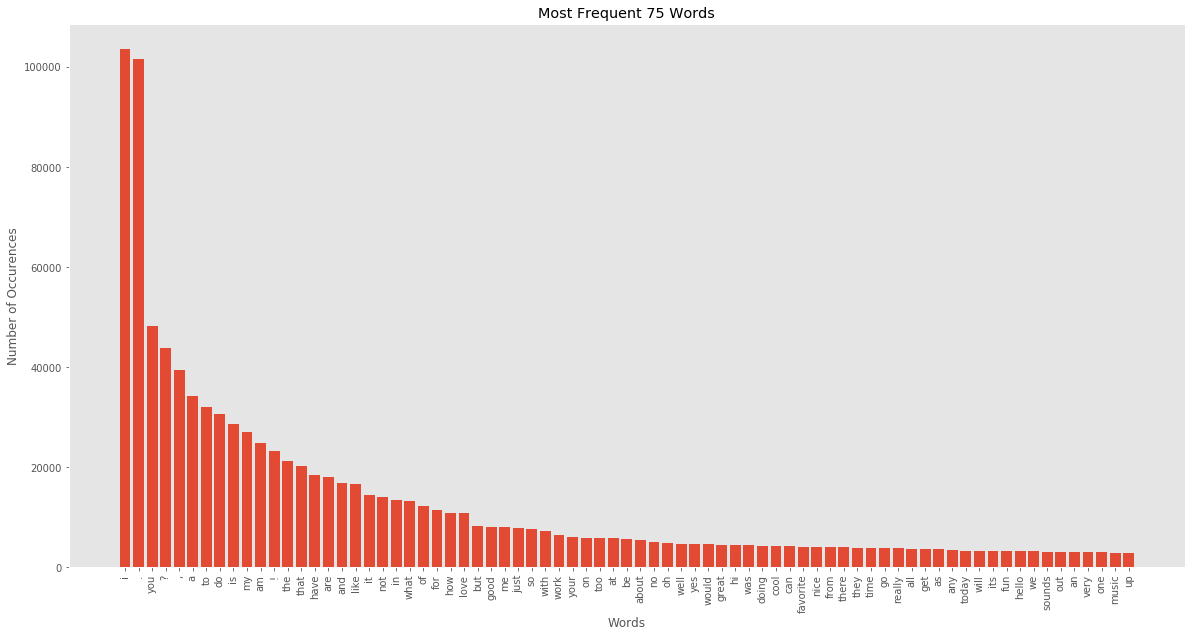

In [8]:
# Most frequent 75 words and their frequencies
words = [x[0] for x in sorted_dict[:75]] 
freqs = [x[1] for x in sorted_dict[:75]]
print(words)
print(freqs)
fig = plt.figure(figsize=(20,10))
plt.bar( x = words,
         height = freqs)
plt.xticks(words, rotation=90)
plt.xlabel("Words")
plt.ylabel("Number of Occurences")
plt.title("Most Frequent 75 Words")
plt.show()

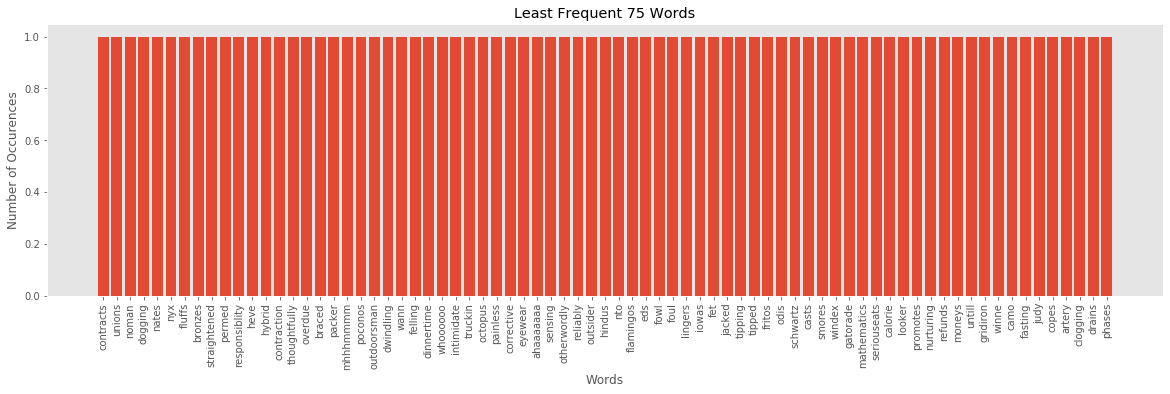

In [9]:
# Least frequent 75 words and their frequencies
words = [x[0] for x in sorted_dict[-75:]] 
freqs = [x[1] for x in sorted_dict[-75:]]
fig = plt.figure(figsize=(20,5))
plt.bar( x =words,
         height = freqs)
plt.xticks(words, rotation=90)
plt.xlabel("Words")
plt.ylabel("Number of Occurences")
plt.title("Least Frequent 75 Words")
plt.show()

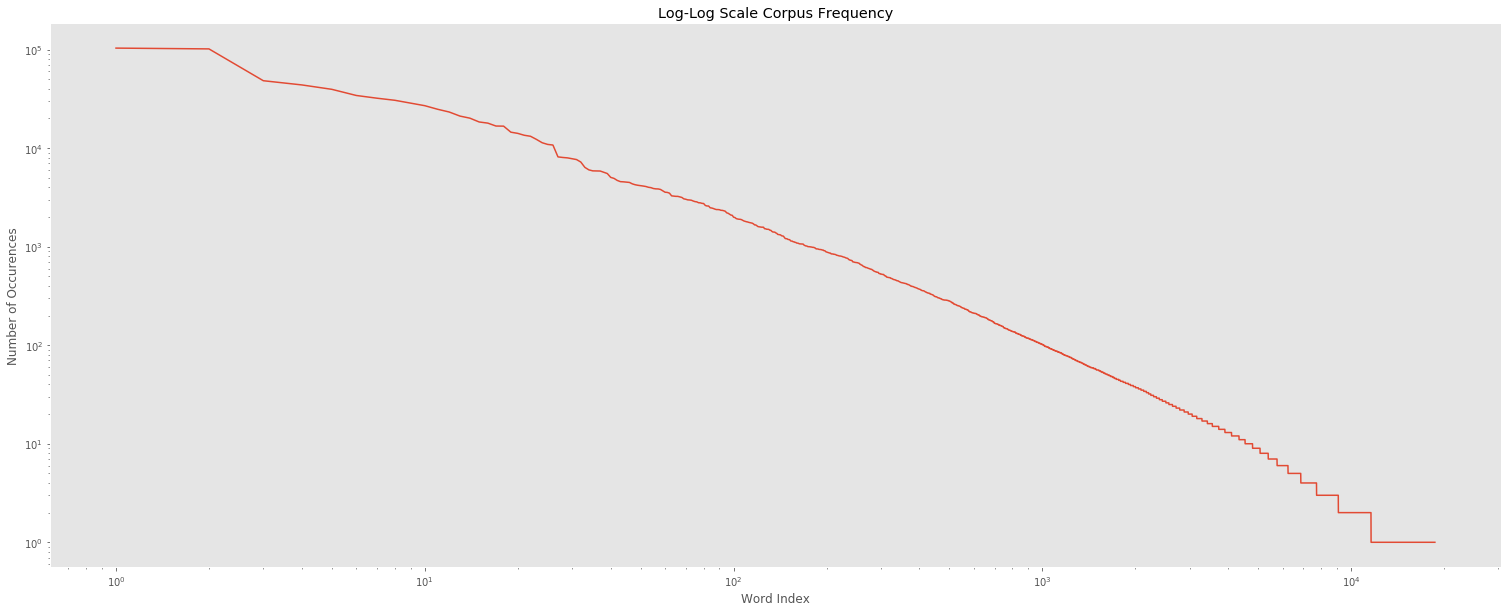

In [10]:
# Log-Log plot of frequeny of words and their rank in the corpus
words_index = np.arange(1, len(sorted_dict)+1, 1)
freqs = [x[1] for x in sorted_dict ]
fig = plt.figure(figsize=(26,10))
plt.loglog( words_index,freqs)
plt.xlabel("Word Index")
plt.ylabel("Number of Occurences")
plt.title("Log-Log Scale Corpus Frequency")
plt.show()

In [11]:
freq_1 = freqs.count(1)
#sum(1 for value in word_dict.values() if value == 1) 
print("Number of words appeared only once in the entire dataset:", freq_1)

Number of words appeared only once in the entire dataset: 7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: We chose the threshold frequency for filtering as 20. The number of unique words decreased from 18673 to 2965 , which means a decrease of 15708 words due to rare event suppression.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: When sentences with filtered words ( words have frequency up to and including 20 ) are excluded, the number of sentences in the filtered dataset decreased to 88100, from the original sentence count of 131424. This means that 43324 sentences are filtered.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: Rare words would cause the learning algorithm to chose those words at the expense of more frequent words because they corresponds a specific sentence; however, their usage in another conversation is very unlikely. Hence, it is better to exclude rare words from the dataset to avoid overfitting.

In [12]:
freqs = np.asarray([x[1] for x in sorted_dict ])
words = np.asarray([x[0] for x in sorted_dict ])

In [13]:
sentencelist = [x.split(' ') for x in conlist]

In [18]:
least_freq_words = words[freqs<=20]
filteredlist = []
for sent in sentencelist:
    if not any ([w in sent for w in least_freq_words]):
#         print(val, least_freq_words[[w in sent for w in least_freq_words]], sent)
        filteredlist.append(sent)

In [19]:
print('The number of sentence in the filtered dataset: ', len(filteredlist))
print('The number of sentence in the original dataset: ', len(conlist))
print('The Number of filtered sentences: ', len(conlist) - len(filteredlist))

The number of sentence in the filtered dataset:  88100
The number of sentence in the original dataset:  131424
The Number of filtered sentences:  43324


In [20]:
# Concatenate lits of list to single list
filtered_wordlist = [y for x in filteredlist for y in x]
filtered_dict = form_dict(filtered_wordlist)
filtered_dict = sorted(filtered_dict.items(), key=operator.itemgetter(1), reverse = True)

In [21]:
print('The number of unique words decreased from', len(word_dict), 'to', len(filtered_dict), ', which means a decrease of',
      len(word_dict) - len(filtered_dict), 'words due to rare event suppression.')

The number of unique words decreased from 18673 to 2965 , which means a decrease of 15708 words due to rare event suppression.


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [22]:
filtered_words = ['PADD'] + ['START'] + ['END'] + [x[0] for x in filtered_dict ]
# Form the dictionary to convert words to ints
int_dict = {}
for idx, word in enumerate(filtered_words):
    int_dict[word] = idx

In [23]:
# Add START and END to each sentence
for idx, sent in enumerate(filteredlist):
    filteredlist[idx] = ['START'] + sent + ['END']

In [24]:
#Replace Strings to Integers
sentToInt = [[int_dict[x] for x in sent] for sent in filteredlist]

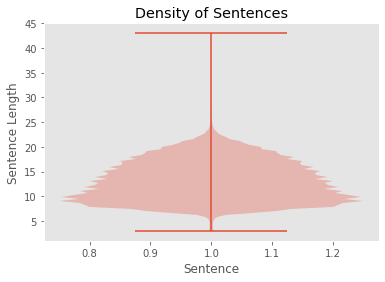

In [25]:
# The violin plot of the sentence lengths of the filtered list with tokenization
fig = plt.figure()
plt.violinplot(dataset = [len(x) for x in sentToInt])
plt.xlabel("Sentence")
plt.ylabel("Sentence Length")
plt.title("Density of Sentences")
plt.show()


In [26]:
# We choose maxlen = 20, where we cover at least 95% of the lenght distribution of the sentences 
maxlen = 20
tokenized_sent = pad_sequences(sentToInt, maxlen=maxlen, padding = 'post')

In [27]:
int_to_word = {b:a for a, b in int_dict.items()} 
# Generate random integers
r1, r2 = np.random.randint(0, len(tokenized_sent)-1 , 2)
sent1 = [x for x in tokenized_sent[r1] if (x >2)]
sent2 = [x for x in tokenized_sent[r2] if (x >2)]
sent1 = [ int_to_word[x] for x in sent1 ]
sent2 = [ int_to_word[x] for x in sent2 ]
print('First Random Sentence: ', " ".join(filteredlist[r1][1:-1]))
print('First Random Sentence Translated: ', " ".join(sent1))
print('Second Random Sentence:', " ".join(filteredlist[r2][1:-1]))
print('Second Random Sentence Translated:', " ".join(sent2))

First Random Sentence:  wow , is that something you really like to do ?
First Random Sentence Translated:  wow , is that something you really like to do ?
Second Random Sentence: yes on our burgers . . . i needed gas for my blue honda civic
Second Random Sentence Translated: yes on our burgers . . . i needed gas for my blue honda civic


### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [28]:
import pickle
#save
with open("data10.pkl", "wb") as file:
    pickle.dump([filteredlist, int_dict, tokenized_sent], file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** Because we set **mask_zero** as true, PADD does not affect the embeddings. Basically, embeddings assign the same value of whatever the precedeing word has to the PADD, which in our case is END since we added END at the end of each sentences and also padding was reversed.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** These networks approximate transition probablities of words in a contex as following: 
    
- it takes a sentence (sequence of words) consisting of integer representation of words in a dictionary as input 
- then it calculates how likely word x^(i+1) will come after x^(i) in a sentence (also co-occurance frequency)
- by considering time distribution, it accumulates probabilty of words in a position in a sentence.  The decision making is also affected from the previous time steps, which are the preceeding words in the same sentence.

For our experiment, we set maximum sentence length as 20, where cover al least 95% of length distribution of sentences. Therefore our input tensor is of size (88100, 19) where 88100 is number of sentences in our dataset. Output tensor is of size (88100 , 19, 2968) where 2968 is size of our dictionary. Since batch size is chosen 64, for each batch the first index of tuples was 64 and rest is same. 

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: The best recurrent unit is GRU with validation accuracy 0.4 (0.39948) Fastest learner is also GRU.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: After 10-15 epoch, we started observing effects of overfitting. The overfitting was much more obvious in the GRU and RNN models. The validation accuracies did not improve more while training accuracies was increasing after 10-15th epochs. Moreover, their validation losses increased as training losses decreased. The effect is less obvious in the LSTM model; however, the validation improvements became much less when compared with same amount of training. Possible explanation might be that the dataset is too small comparing to number of paramaters we attempted to optimize. (thoundres of tousands)

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: We can increase size of the dataset by collecting more data to train, which would decrease the bias towards the dataset.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: We can add dropout layer, which would decrease overfitting by removing some neurons and relaxing the model.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: We can decrease the number of epochs, which would prevent overfitting by training less, stopping earlier.

In [14]:
import pickle
#load
with open("data10.pkl", "rb") as file:
    [filteredlist, int_dict, tokenized_sent] = pickle.load(file)

In [15]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.
maxlen = len(tokenized_sent[0])

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [16]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [32]:
# Model suggestion
# RNN Model

I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(int_dict), embedding_size, mask_zero=True, name="embedding")(I['RNN'])

#your network here
H['RNN'] = SimpleRNN(hidden_size, activation='tanh', return_sequences = True)(E['RNN']) #... Recurrent layer(s)

#R['RNN'] = H['RNN']#... Readout
Y['RNN'] = TimeDistributed(Dense(len(int_dict), activation='softmax'))(H['RNN'])#... Output

models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()



Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           379904    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 19, 64)            12352     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 2968)          192920    
Total params: 585,176
Trainable params: 585,176
Non-trainable params: 0
_________________________________________________________________


In [5]:
X = tokenized_sent
T = keras.utils.to_categorical(X, num_classes = len(int_dict))

In [35]:
print(X[:,:-1].shape, T[:,1:].shape)

logs['RNN'] = models['RNN'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history


#save
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN'], file)
models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

(88100, 19) (88100, 19, 2968)
Instructions for updating:
Use tf.cast instead.
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [==============================] - 89s 1ms/step - loss: 4.4775 - acc: 0.2297 - val_loss: 3.7514 - val_acc: 0.3300
Epoch 2/32
70479/70479 [==============================] - 89s 1ms/step - loss: 3.5774 - acc: 0.3482 - val_loss: 3.4698 - val_acc: 0.3585
Epoch 3/32
70479/70479 [==============================] - 89s 1ms/step - loss: 3.3822 - acc: 0.3658 - val_loss: 3.3572 - val_acc: 0.3686
Epoch 4/32
70479/70479 [==============================] - 89s 1ms/step - loss: 3.2802 - acc: 0.3743 - val_loss: 3.2942 - val_acc: 0.3738
Epoch 5/32
70479/70479 [==============================] - 89s 1ms/step - loss: 3.2144 - acc: 0.3807 - val_loss: 3.2535 - val_acc: 0.3781
Epoch 6/32
70479/70479 [==============================] - 89s 1ms/step - loss: 3.1665 - acc: 0.3849 - val_loss: 3.2261 - val_acc: 0.3803
Epoch 7/32
70479/70479 [==========================

In [33]:
# Weights of embedded layer after training 
models['RNN'].layers[1].get_weights()

[array([[ 0.03466251, -0.02753857,  0.04425294, ..., -0.02018461,
          0.00723144, -0.0153519 ],
        [ 0.00394664, -0.04885766, -0.04301786, ..., -0.03738769,
         -0.00114181,  0.03439175],
        [-0.03176575, -0.00714301,  0.01837193, ...,  0.04250939,
         -0.0477361 ,  0.00233956],
        ...,
        [-0.03064481, -0.04484462, -0.02752991, ...,  0.01047243,
          0.03476939,  0.02861345],
        [ 0.00776048, -0.0496689 , -0.00542386, ..., -0.04095114,
         -0.04549053,  0.04567553],
        [-0.02895231,  0.04936429,  0.02634963, ..., -0.04878498,
         -0.00392026, -0.02036983]], dtype=float32)]

In [ ]:
#Model suggestion
# LSTM Model

I['LSTM'] = Input(shape=(maxlen-1,), name="input")
E['LSTM'] = Embedding(len(int_dict), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])

#your network here
H['LSTM'] = LSTM(hidden_size, activation='tanh', return_sequences = True)(E['LSTM']) #... Recurrent layer(s)

#R['LSTM'] = H['LSTM']#... Readout
Y['LSTM'] = TimeDistributed(Dense(len(int_dict), activation='softmax'))(H['LSTM'])#... Output

models['LSTM'] = Model(inputs = [I['LSTM']], outputs = [Y['LSTM']])
models['LSTM'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['LSTM'].summary()

logs['LSTM'] = models['LSTM'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['LSTM'], file)
models['LSTM'].save("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           379904    
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 64)            49408     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 2968)          192920    
Total params: 622,232
Trainable params: 622,232
Non-trainable params: 0
_________________________________________________________________
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [==============================] - 102s 1ms/step - loss: 5.0632 - acc: 0.1589 - val_loss: 4.5563 - val_acc: 0.2307
Epoch 2/32
70479/70479 [==============================] - 101s 1ms/step - loss: 

In [ ]:
# Model suggestion
# GRU Model

I['GRU'] = Input(shape=(maxlen-1,), name="input")
E['GRU'] = Embedding(len(int_dict), embedding_size, mask_zero=True, name="embedding")(I['GRU'])

#your network here
H['GRU'] = GRU(hidden_size, activation='tanh', return_sequences = True)(E['GRU']) #... Recurrent layer(s)

#R['GRU'] = H['GRU']#... Readout
Y['GRU'] = TimeDistributed(Dense(len(int_dict), activation='softmax'))(H['GRU'])#... Output

models['GRU'] = Model(inputs = [I['GRU']], outputs = [Y['GRU']])
models['GRU'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU'].summary()

logs['GRU'] = models['GRU'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU'], file)
models['GRU'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

In [14]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    LSTMmodel_log = pickle.load(file)
LSTMmodel = load_model("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    GRUmodel_log = pickle.load(file)
GRUmodel = load_model("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [15]:
np.max(GRUmodel_log['val_acc'])

0.39948427776608375

In [16]:
# These code is taken from Miniproject 1

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(8)
    fig.set_figwidth(13)
    
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    fig.set_figheight(8)
    fig.set_figwidth(13)
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    fig.set_figheight(8)
    fig.set_figwidth(13)
    
    ax1.plot(history_sgd['loss'], label=label1 + ' training' )
    ax1.plot(history_sgd['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam['loss'], label=label2 + ' training')
    ax1.plot(history_adam['val_loss'], label=label2 + ' validation')
    ax1.legend(loc='lower left')
    
    ax2.plot(history_sgd['acc'], label=label1 + ' training')
    ax2.plot(history_sgd['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam['acc'], label=label2 + ' training')
    ax2.plot(history_adam['val_acc'], label=label2 + ' validation')
    ax2.legend(loc='lower left')
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

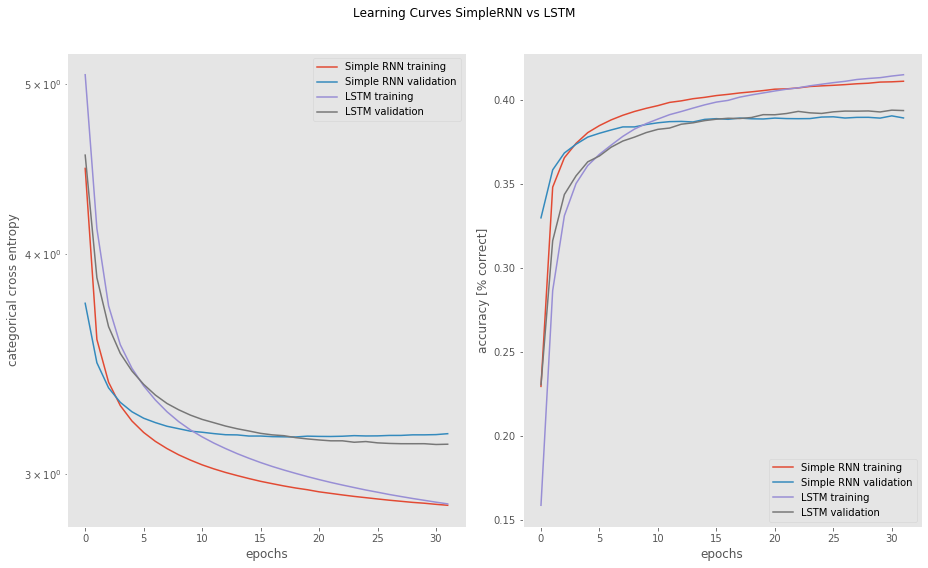

In [17]:
comparison_plot(RNNmodel_log, LSTMmodel_log, 'Simple RNN', 'LSTM', 'Learning Curves SimpleRNN vs LSTM' );

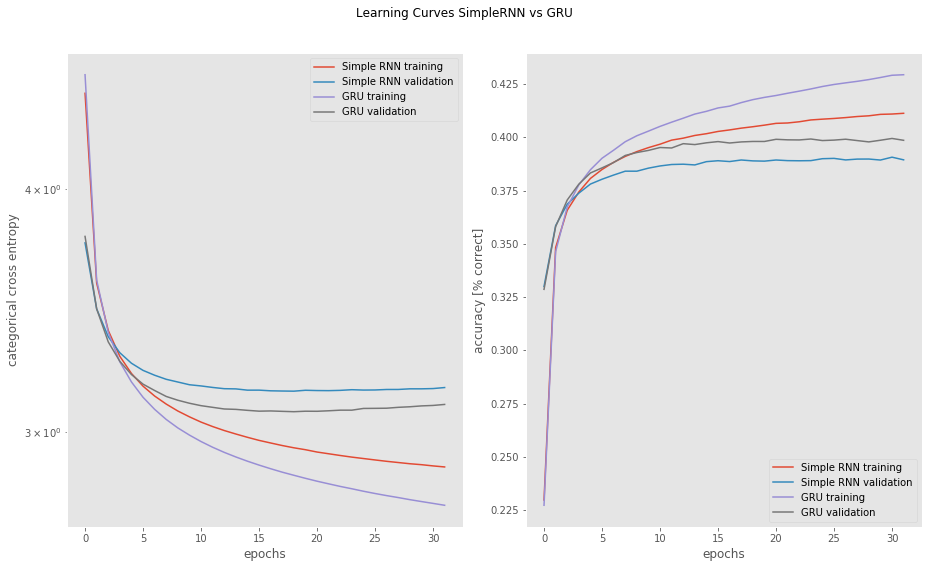

In [18]:
comparison_plot(RNNmodel_log, GRUmodel_log, 'Simple RNN', 'GRU', 'Learning Curves SimpleRNN vs GRU' );

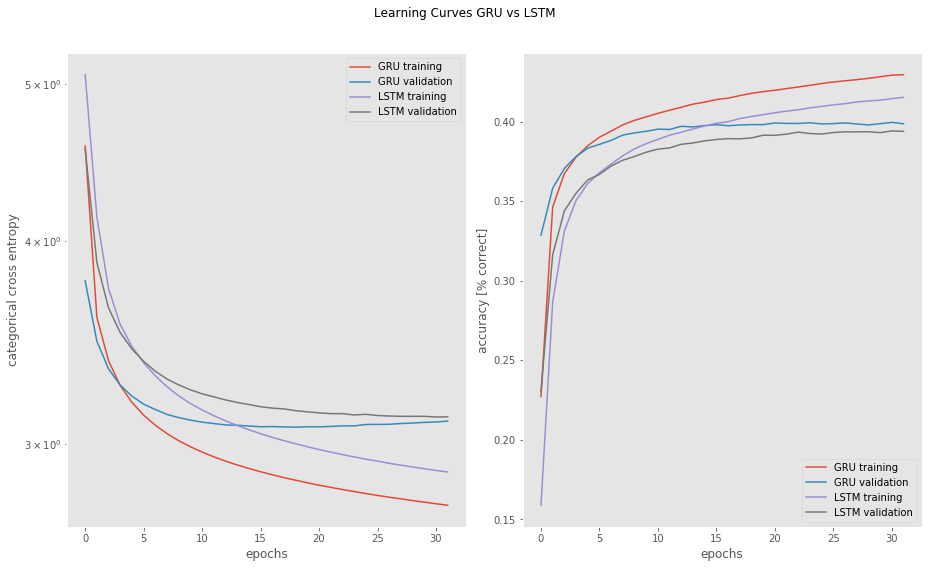

In [19]:
comparison_plot(GRUmodel_log, LSTMmodel_log, 'GRU', 'LSTM', 'Learning Curves GRU vs LSTM' );

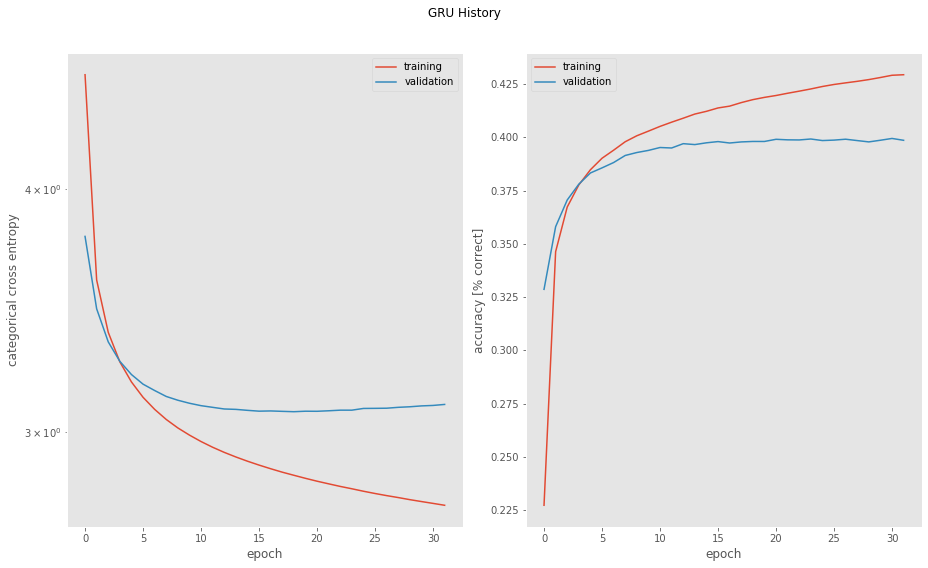

In [25]:
plot_history(GRUmodel_log, 'GRU History');

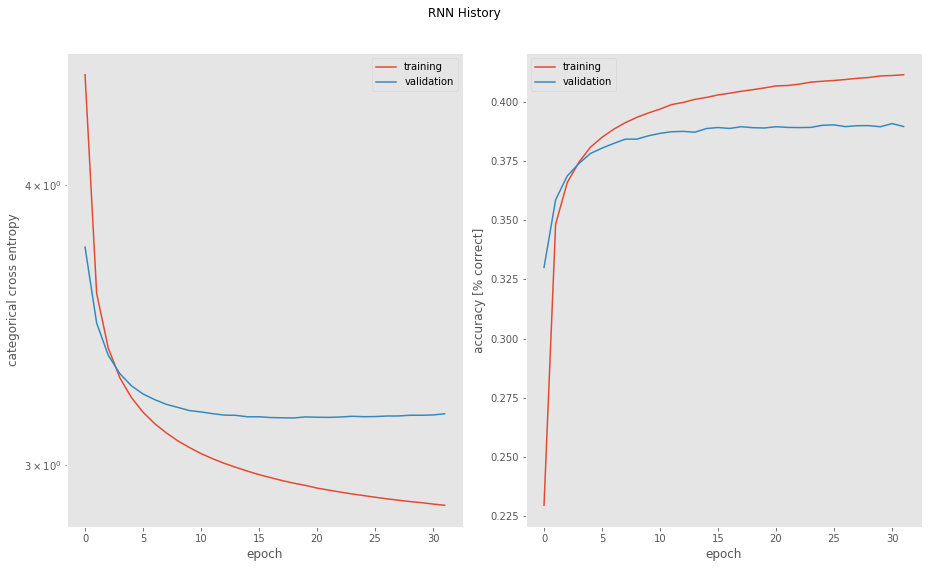

In [26]:
plot_history(RNNmodel_log, 'RNN History');

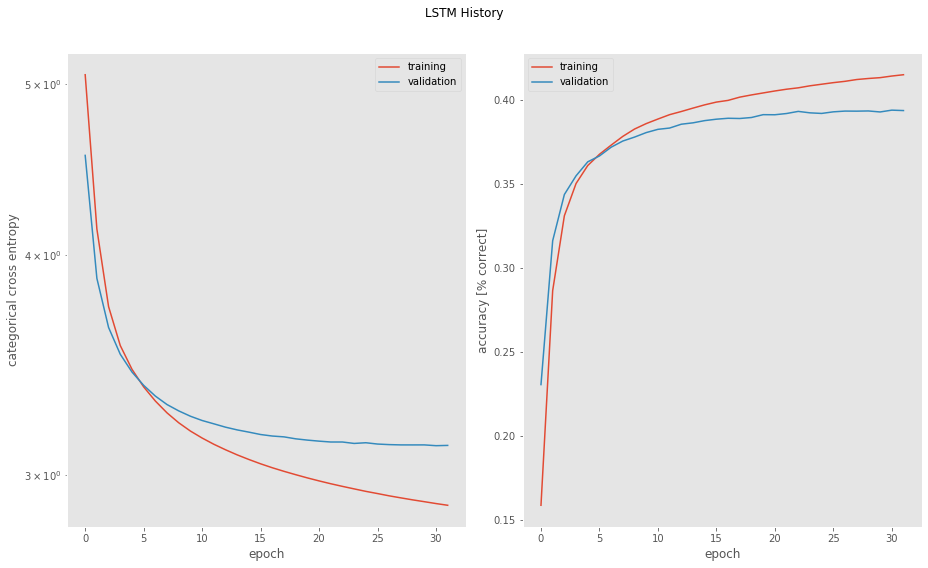

In [27]:
plot_history(LSTMmodel_log, 'LSTM History');

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** When there are more layers in the recurrent part, it makes the learning curve steeper. The layer count difference results in a worse accuracy in the 2-layer architecture, but it catches up quickly by learning faster. However, this also results in a quick overfitting.


**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** It significantly decreased the number of epochs for training. (Also the effect of transferred embedding layer) One advantage of Early Stopping is that it prevents overfitting and keeps the validation accuracy at a reasonable level. One drawback is that Early Stopping prevents the model from getting to a better minimum, if it exists.

**Question** What is your best model? Why? [1 pt]

**Answer** GRU with 256 hidden units was the best model, because it has the highest validation accuracy.



In [ ]:
#GRU with 128 hidden units
hidden_size = 128

I['GRU128'] = Input(shape=(maxlen-1,), name="input")
E['GRU128'] = Embedding(len(int_dict), embedding_size, mask_zero=True, name="embedding")(I['GRU128'])

#your network here
H['GRU128'] = GRU(hidden_size, activation='tanh', return_sequences = True)(E['GRU128']) #... Recurrent layer(s)

#R['GRU128'] = H['GRU128']#... Readout
Y['GRU128'] = TimeDistributed(Dense(len(int_dict), activation='softmax'))(H['GRU128'])#... Output

models['GRU128'] = Model(inputs = [I['GRU128']], outputs = [Y['GRU128']])
models['GRU128'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU128'].summary()

#Transfer Learning to send weights from the GRU in last exercise
models['GRU128'].layers[1].set_weights(GRUmodel.layers[1].get_weights())

logs['GRU128'] = models['GRU128'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)]).history

#save
with open("GRU128model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU128'], file)
models['GRU128'].save("GRU128model_"+str(embedding_size)+'_'+str(hidden_size))

In [ ]:
#GRU with 256 hidden units
hidden_size = 256

I['GRU256'] = Input(shape=(maxlen-1,), name="input")
E['GRU256'] = Embedding(len(int_dict), embedding_size, mask_zero=True, name="embedding")(I['GRU256'])

#your network here
H['GRU256'] = GRU(hidden_size, activation='tanh', return_sequences = True)(E['GRU256']) #... Recurrent layer(s)

#R['GRU256'] = H['GRU256']#... Readout
Y['GRU256'] = TimeDistributed(Dense(len(int_dict), activation='softmax'))(H['GRU256'])#... Output

models['GRU256'] = Model(inputs = [I['GRU256']], outputs = [Y['GRU256']])
models['GRU256'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU256'].summary()

#Transfer Learning to send weights from the GRU in last exercise
models['GRU256'].layers[1].set_weights(GRUmodel.layers[1].get_weights())

logs['GRU256'] = models['GRU256'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)]).history

#save
with open("GRU256model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU256'], file)
models['GRU256'].save("GRU256model_"+str(embedding_size)+'_'+str(hidden_size))

In [33]:
#GRU with 64 hidden units, 2 layers
hidden_size = 64

I['GRU6464'] = Input(shape=(maxlen-1,), name="input")
E['GRU6464'] = Embedding(len(int_dict), embedding_size, mask_zero=True, name="embedding")(I['GRU6464'])

#your network here
H['GRU6464'] = GRU(hidden_size, activation='tanh', return_sequences = True)(E['GRU6464']) #... Recurrent layer(s)
R['GRU6464'] = GRU(hidden_size, activation='tanh', return_sequences = True)(H['GRU6464']) 
Y['GRU6464'] = TimeDistributed(Dense(len(int_dict), activation='softmax'))(R['GRU6464'])#... Output

models['GRU6464'] = Model(inputs = [I['GRU6464']], outputs = [Y['GRU6464']])
models['GRU6464'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU6464'].summary()

#Transfer Learning to send weights from the GRU in last exercise
models['GRU6464'].layers[1].set_weights(GRUmodel.layers[1].get_weights())

logs['GRU6464'] = models['GRU6464'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)]).history

#save
with open("GRU6464model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU6464'], file)
models['GRU6464'].save("GRU6464model_"+str(embedding_size)+'_'+str(hidden_size))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           379904    
_________________________________________________________________
gru_3 (GRU)                  (None, 19, 64)            37056     
_________________________________________________________________
gru_4 (GRU)                  (None, 19, 64)            24768     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 2968)          192920    
Total params: 634,648
Trainable params: 634,648
Non-trainable params: 0
_________________________________________________________________
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [==============================] - 122s 2ms/step - loss: 4.4936

In [17]:
with open("GRUmodel_"+str(embedding_size)+'_'+str(64)+"_log.pkl", "rb") as file:
    GRUmodel_log = pickle.load(file)
GRUmodel = load_model("GRUmodel_"+str(embedding_size)+'_'+str(64))

with open("GRU128model_"+str(embedding_size)+'_'+str(128)+"_log.pkl", "rb") as file:
    GRU128model_log = pickle.load(file)
GRU128model = load_model("GRU128model_"+str(embedding_size)+'_'+str(128))

with open("GRU256model_"+str(embedding_size)+'_'+str(256)+"_log.pkl", "rb") as file:
    GRU256model_log = pickle.load(file)
GRU256model = load_model("GRU256model_"+str(embedding_size)+'_'+str(256))

with open("GRU6464model_"+str(embedding_size)+'_'+str(64)+"_log.pkl", "rb") as file:
    GRU6464model_log = pickle.load(file)
GRU6464model = load_model("GRU6464model_"+str(embedding_size)+'_'+str(64))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


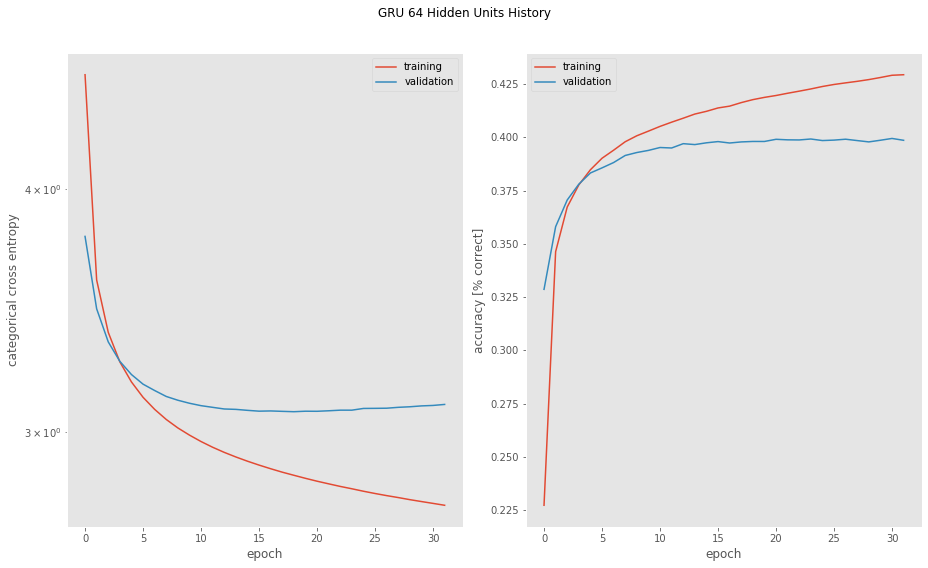

In [36]:
plot_history(GRUmodel_log, 'GRU 64 Hidden Units History');

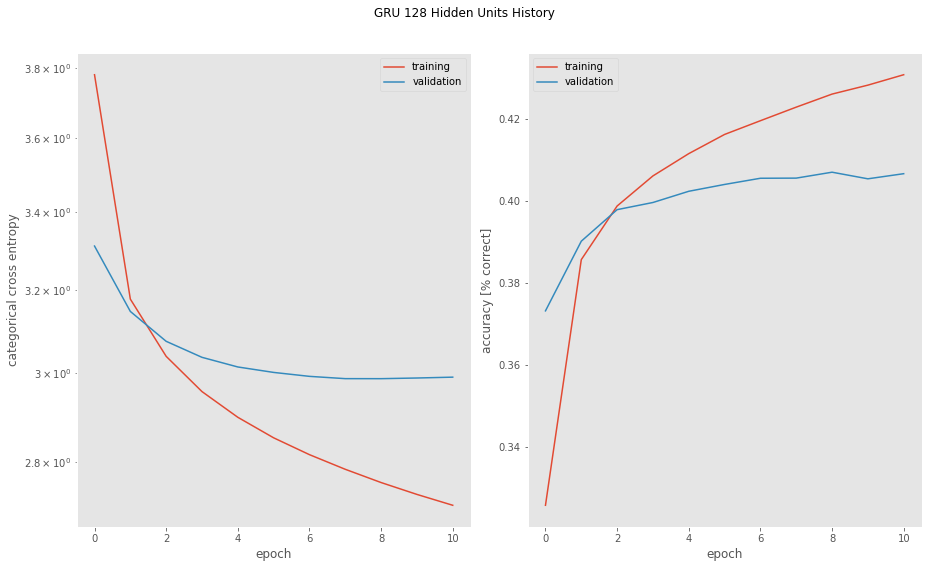

In [37]:
plot_history(GRU128model_log, 'GRU 128 Hidden Units History');

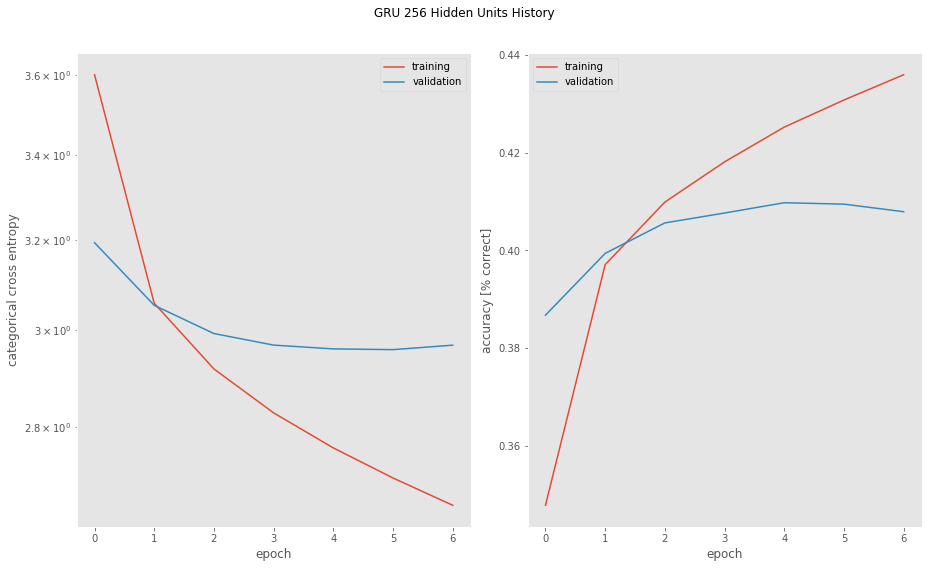

In [38]:
plot_history(GRU256model_log, 'GRU 256 Hidden Units History');

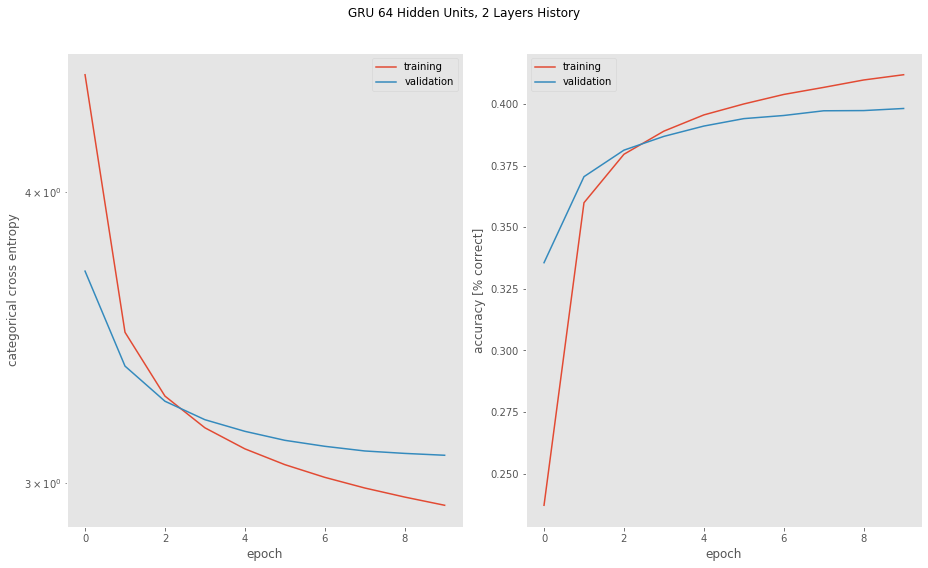

In [39]:
plot_history(GRU6464model_log, 'GRU 64 Hidden Units, 2 Layers History');

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Sampling temperature adds randomization to the sentence generation. When temperature is 0, no randomization yields generation of the same sentence all the time. As temperature increases, the sentence generation becomes randomized, and depends more on the randomization, less on the model.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** It is as if you are sampling a constant, you just take the maximum probability.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** The prediction probabilities are given as an input probabilities to a multinomial distribution and the output is the maximum of the samples of the multinomial distribution. This makes higher probabilities a higher chance of getting to the output, but it is definitely randomized.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** A very high sampling temperature means that the sampling does not depend much on the model, it is truly random. Hence, the sampling provides gets zeros information from the model and the output would be a sample from the uniform distribution on the dictionary.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** The first sentence with only START is sent as an input to the model. Then, the word transition probabilities for the next word are fed to the sample, which yields a result randomized according to its temperature. Then, this result is added to the sentence after START. Then, the same is done for the next word, and this continues until reaching END or hitting the maximum length. Hence, we have high probabilities on the diagonals, the next word is likely the one chosen.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes. For example, at temperature 0.5, both "I" and "is" are likely after "who". Here, it can be observed that the model actually learns the rules of the language itself. Another example is that both "a" and "not" are likely after "I have" in the same sentence. Hence, it learns the grammatical structures of creating a sentence by learning which word is likely to follow which word. So, the words have similar grammatical structures.

In [29]:
# helper function to sample an index from a probability array
def sample(preds, temperature=1.):
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def default_init():
    # Initialize the sentence
    input_sentence = ['START']
    for i in range(1,maxlen):
        input_sentence.append('PADD')
    input_tokens = np.array( [[int_dict[x] for x in input_sentence]] )
    return input_tokens


In [30]:
# generate a sentence from given model
# input_tokens is START 0 0....END sentence
def generate_sentence(model, temperature, input_tokens):

    input_predicted = []
    end_for = False
    # Generate the sentence
    for i in range(maxlen-1):
        input_preds = model.predict(input_tokens[:,:-1])
        input_predicted.append(input_preds[0,i])
        if end_for:
            break
        output = sample(input_preds[0,i], temperature)
        input_tokens[0,i+1] = output
        if output == 2:
            end_for = True
    return input_tokens[0], input_predicted

In [132]:
# Helper function to create conversation fro given context
# input_tokens is contex sentence
def continue_sentence(model, temperature, input_tokens, input_size):

    input_predicted = []
    end_for = False
    # Generate the sentence
    for i in range(input_size, maxlen-1):
        input_preds = model.predict(input_tokens[:,:-1])
        input_predicted.append(input_preds[0,i])
        if end_for:
            break
        output = sample(input_preds[0,i], temperature)
        input_tokens[0,i+1] = output
        if output == 2:
            end_for = True
    return input_tokens[0], input_predicted

In [31]:
# Translation from numbers to natural language domain
int_to_word = {b:a for a, b in int_dict.items()}
def translate(sentence):
    sent1 = [x for x in sentence if (x > 2)]
    sent1 = [ int_to_word[x] for x in sent1 ]
    return " ".join(sent1)


In [125]:
# Generate 10 sentences of different temperatures
num_sentences = 10
temperatures = [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]
sample_sents = []
sample_preds = []
for temp in temperatures:
    print('Temperature:', temp)
    for i in range(num_sentences):
        sentence, preds = generate_sentence(GRU256model, temp, default_init())
        print( translate(sentence) )
    sample_sents.append([x for x in sentence if x > 0])
    sample_preds.append(preds)

Temperature: 0.0
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
i am doing good . just playing some video games .
Temperature: 0.25
i do not have any pets , i do not have any pets .
i like to read books and i love the outdoors .
i am doing good . just playing some video games .
i am good . how are you ?
i am doing good . just playing some video games .
i am doing good . just getting ready to go out and i love to eat steak .
i do not have a lot of friends . i have to have two cats .
i am doing good . i am just getting ready to go out and i like to eat it
i love to shop for the weekend .
i am

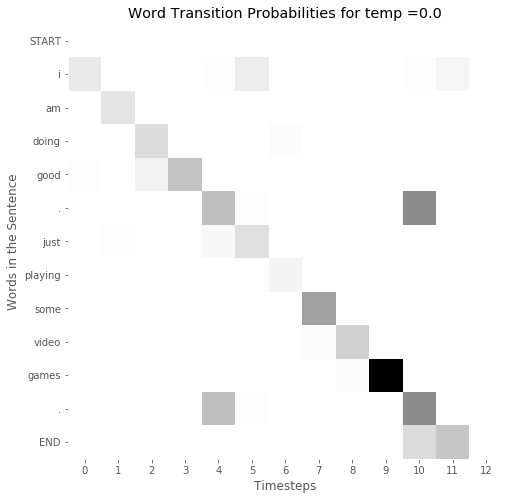

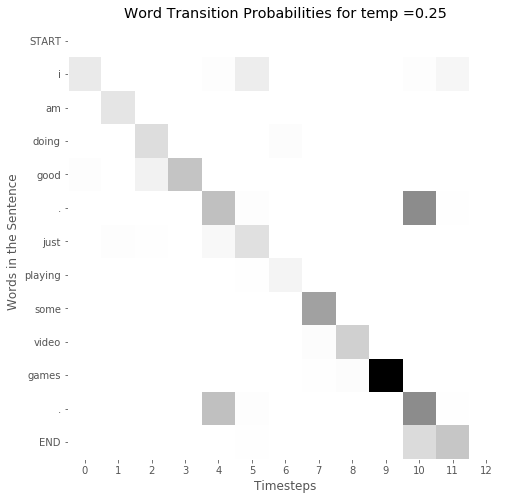

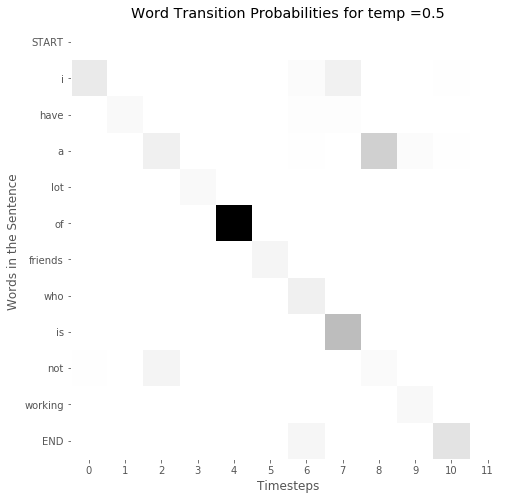

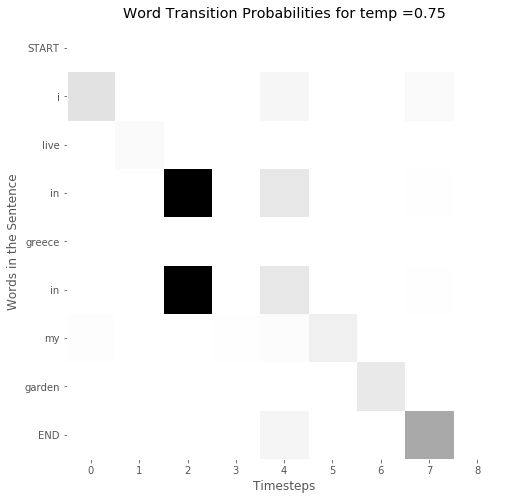

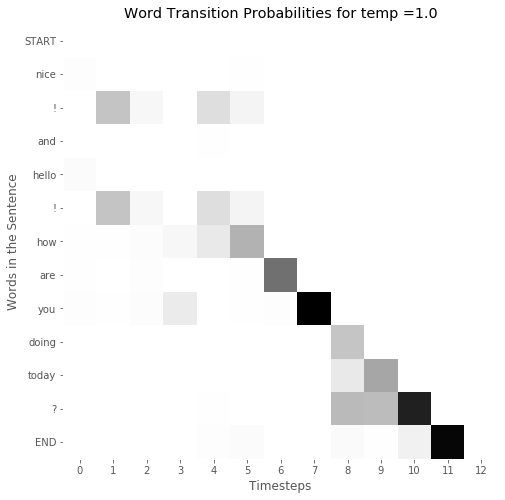

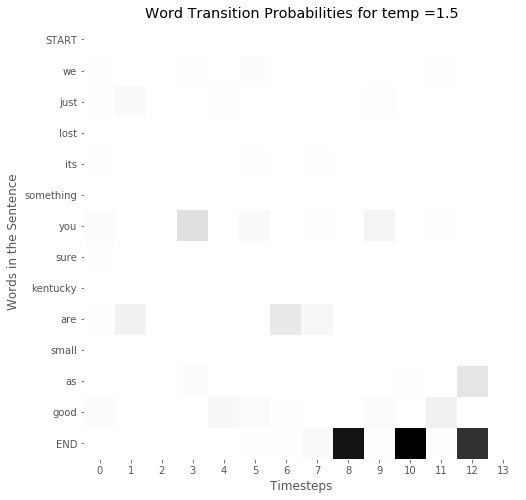

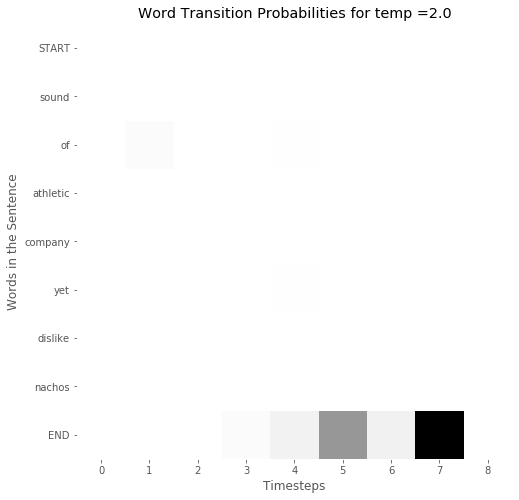

In [126]:
#Plot the Word Transition Probability Images
for sent_idx, sentence in enumerate(sample_sents):
    X = []
    for x_idx in range(len(sample_preds[sent_idx])):
        X.append(sample_preds[sent_idx][x_idx][np.asarray(sample_sents[sent_idx])])
        
    X = np.asarray(X)
    X = X.T
    
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(13)
    plt.title('Word Transition Probabilities for temp =' + str(temperatures[sent_idx]))
    plt.ylabel('Words in the Sentence')
    plt.xlabel('Timesteps')
    sent_trans = [int_to_word[x] for x in sentence]
    plt.yticks(range(len(sent_trans)), sent_trans)
    plt.xticks(range(len(sentence)))
    
    plt.imshow(X, cmap='Greys')
    plt.show()
    
        

In [141]:
# Select two different 4 word beginnings
# Lets choose high temperature samples for funny sentences
chosen = [sent[:4] for sent in sample_sents if len(sent) >= 4]
chosen = np.asarray(chosen[-2:])

chosen = pad_sequences(chosen, maxlen=20, padding='post')

#Print the beginnings
print('Beginning 1:', translate(chosen[0]))
print('Beginning 2:', translate(chosen[1]))
    

Beginning 1: we just lost
Beginning 2: sound of athletic


In [142]:
chosen

array([[   1,   77,   32,  597,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,  297,   26, 1617,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [149]:
for c in range(2):
    print('Continuation for:', translate(chosen[c]))
    for i in range(10):
        to_cont = np.asarray([chosen[c]])
        print(translate(continue_sentence(GRU256model, 1, to_cont, 4)[0]))
    print()

Continuation for: we just lost
we just lost my 3 kids here . ever do a named george , todd ?
we just lost but my parents are both graphic salesman
we just lost my get lost in my creative studies
we just lost my last car
we just lost a bear , looking online for my job .
we just lost in first grade living
we just lost my parents died
we just lost it is my hobby
we just lost you ? hear about i get half day easy to climb
we just lost some people from life , and yours ?

Continuation for: sound of athletic
sound of athletic they get hurt from local farm
sound of athletic , i could help you to go to college as i actually do !
sound of athletic . do you have any hobbies ?
sound of athletic , whats your favorite team ?
sound of athletic . do you live where you live ? even give me a happy person
sound of athletic . i also put all a christian .
sound of athletic , do you have any pets ?
sound of athletic . i want to do that show to play for the city
sound of athletic . the people are all of my f

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** Yes we observed. For example, punctuations (?.!) appeared very close to each other as well as adjectives (cool, nice, fun, interesting) and different forms of same verbs (have-had, go-going) 

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** This representations show that our model was able to catch the semantic and inner relation of the words among each other, which naturally occurs in each language. We could have designed such a representation for a corpus but these relations were extracted from the context. Therefore, they are context depended. However, using example clusters may help especially when infering the grammatical rules. These cluster may improve generalization but may decrease prediction accuracy for given context.

In [39]:
from sklearn.manifold import TSNE

In [63]:
# Select 200 most frequent words and design an input that the model understands
X_embed = [ [ int_dict[(x[0])]   ]   for x in sorted_dict[:200]]
X_embed = pad_sequences(X_embed, maxlen=19, padding = 'post')punctuation
X_embed

array([[  3,   0,   0, ...,   0,   0,   0],
       [  4,   0,   0, ...,   0,   0,   0],
       [  5,   0,   0, ...,   0,   0,   0],
       ...,
       [210,   0,   0, ...,   0,   0,   0],
       [188,   0,   0, ...,   0,   0,   0],
       [197,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [64]:
#GRU with 256 hidden unit
hidden_size = 64

I['Embed'] = Input(shape=(maxlen-1,), name="input")
E['Embed'] = Embedding(len(int_dict), embedding_size, mask_zero=True, name="embedding")(I['Embed'])

models['Embed'] = Model(inputs = [I['Embed']], outputs = [E['Embed']])
models['Embed'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=None)
models['Embed'].summary()


#Transfer Learning to send weights from the GRU in last exercise
models['Embed'].layers[1].set_weights(GRU256model.layers[1].get_weights())

embeddings = models['Embed'].predict(X_embed)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           379904    
Total params: 379,904
Trainable params: 379,904
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Embeedings of the 200 most frequent words
word_embeddings = embeddings[:,0,:]
word_embeddings.shape

(200, 128)

In [78]:
# Project the embeddings from 128D to 2D
words_2D = TSNE(n_components=2).fit_transform(X=word_embeddings)

In [86]:
words200 = [ x[0] for x in sorted_dict[:200]]
words200

['i',
 '.',
 'you',
 '?',
 ',',
 'a',
 'to',
 'do',
 'is',
 'my',
 'am',
 '!',
 'the',
 'that',
 'have',
 'are',
 'and',
 'like',
 'it',
 'not',
 'in',
 'what',
 'of',
 'for',
 'how',
 'love',
 'but',
 'good',
 'me',
 'just',
 'so',
 'with',
 'work',
 'your',
 'on',
 'too',
 'at',
 'be',
 'about',
 'no',
 'oh',
 'well',
 'yes',
 'would',
 'great',
 'hi',
 'was',
 'doing',
 'cool',
 'can',
 'favorite',
 'nice',
 'from',
 'there',
 'they',
 'time',
 'go',
 'really',
 'all',
 'get',
 'as',
 'any',
 'today',
 'will',
 'its',
 'fun',
 'hello',
 'we',
 'sounds',
 'out',
 'an',
 'very',
 'one',
 'music',
 'up',
 'them',
 'lot',
 'some',
 'live',
 'when',
 'much',
 'yeah',
 'now',
 'day',
 'going',
 'play',
 'know',
 'kids',
 'where',
 'been',
 'school',
 'want',
 'lol',
 'got',
 'he',
 'wow',
 'enjoy',
 'job',
 'did',
 'eat',
 'also',
 'make',
 'or',
 'could',
 'more',
 'think',
 'this',
 'she',
 'awesome',
 'though',
 'kind',
 'here',
 'food',
 'dogs',
 'if',
 'should',
 'only',
 'never',
 '

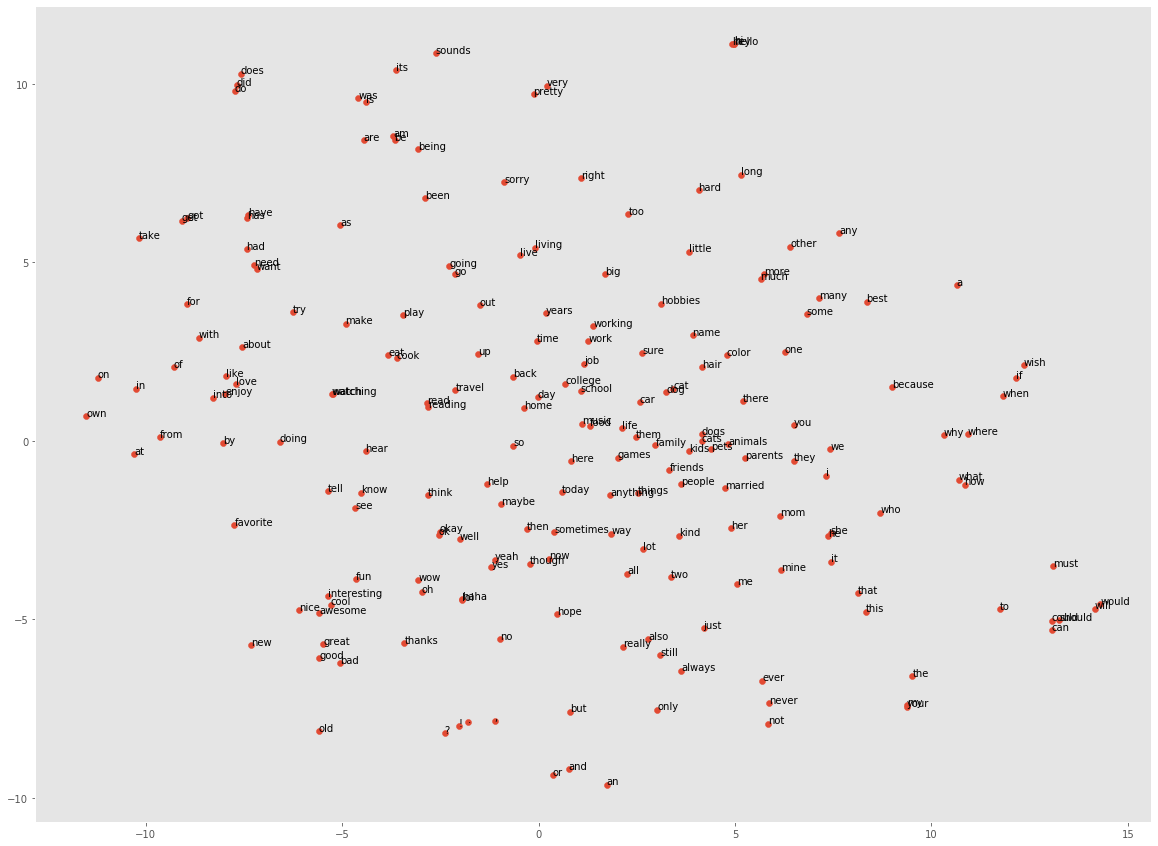

In [96]:
# Scatter plot of words in 2D space
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(20)
ax.scatter(words_2D[:,0],words_2D[:,1])
for i, txt in enumerate(words200):
    ax.annotate(txt, ( (words_2D[:,0])[i], (words_2D[:,1])[i] )  ) 

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer** They are not similar at all. However, this is actually a good thing, because there can be many answers to a single question, and this shows that the model does not stick to the dataset, it does not overfit. The answers are sometimes probable answers, but they are sometimes just absurd. The answers are usually better for more generic contexts, which have more samples in the training dataset.

Here is a good example output:

Context: seems like a good job . can sort of do your own thing .

Chatbot Answer: oh yeah , i suppose i have time for a job very active .

Real Answer: true what do you have planned tonight ?

And here is a bad one:

Context: he sounds like a cool guy . my job is to fix planes .

Chatbot Answer: italian , the doctors would you approve ! what ages traveled are saying ?

Real Answer: he is alright . that is a cool job to have .


**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** It becomes better around 1. Low temperatures result in less randomization, yielding similar answers to all kinds of questions. High temperatures increase randomization, but this time it starts yielding random answers to all questions. Around these two, a temperature of 1 is observed to give better answers.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** Definitely not, this would mean it cannot work on a real-world application. There are many ways to answer to the same context, and the model learning to copy from the dataset means that it can never answer a question out of the context of the database.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [ ]:
# Construct the new dataset of pairs
least_freq_words = words[freqs<=20]
conv_list = []
for idx, conv in enumerate(conversations):
    prev = None
    prev_filtered = True
    for sent in conv:
        if not any ([w in sent.split(' ') for w in least_freq_words]):
            # Do not Filter
            #print(sent, prev_filtered)
            if not prev_filtered:
                conv_list.append([prev, sent])
            prev_filtered = False
            prev = sent
        #Filter and Update
        else:
            prev_filtered = True
            prev = None
    if idx % 100 == 0:
        print(idx, '/', len(conversations))

0 / 8938
100 / 8938
200 / 8938
300 / 8938
400 / 8938
500 / 8938
600 / 8938
700 / 8938
800 / 8938
900 / 8938
1000 / 8938
1100 / 8938
1200 / 8938
1300 / 8938
1400 / 8938
1500 / 8938
1600 / 8938
1700 / 8938
1800 / 8938
1900 / 8938
2000 / 8938
2100 / 8938
2200 / 8938
2300 / 8938
2400 / 8938
2500 / 8938


In [97]:
import pickle
with open("conv_pairs.pkl", "wb") as file:
    pickle.dump(conv_list, file)

In [98]:
len(conv_list)

56148

In [18]:
import pickle
with open("conv_pairs.pkl", "rb") as file:
    conv_list = pickle.load(file)

In [19]:
conv1 = [x[0] for x in conv_list]
conv2 = [ "START " + x[1] + " END" for x in conv_list]

In [20]:
conv2

['START i am spending time with my 4 sisters what are you up to END',
 'START wow , four sisters . just watching game of thrones . END',
 'START that is a good show i watch that while drinking iced tea END',
 'START i agree . what do you do for a living ? END',
 'START that is awesome . i have always had a love for technology . END',
 'START tell me more about yourself END',
 'START i really enjoy free diving , how about you , have any hobbies ? END',
 'START i enjoy hanging with my mother she is my best friend END',
 'START that is nice . moms are pretty cool too . END',
 'START lol . i am shy , anything to break the ice , and i am a beatles fan . END',
 'START i can tell . i am not , you can see me in some tv shows END',
 'START really ? what shows ? i like tv , it makes me forget i do not like my family END',
 'START wow , i wish i had a big family . i grew up in a very small town . END',
 'START i did too . i do not get along with mine . they have no class . END',
 'START are you m

In [21]:
trainC = [ [int_dict[x] for x in sent.split(' ')] for sent in conv1]
trainA = [ [int_dict[y] for y in sent.split(' ')] for sent in conv2]

In [22]:
trainC = pad_sequences(trainC, maxlen=18, padding='post')
trainA = pad_sequences(trainA, maxlen=20, padding='post')
trainA_onehot = np_utils.to_categorical(trainA)

In [117]:
train_A

array([[  1,   3,  12, ...,   0,   0,   0],
       [  1,  93,   7, ...,   0,   0,   0],
       [  1,  15,  11, ...,   0,   0,   0],
       ...,
       [  1,   3,  12, ..., 254,   4,   2],
       [  1,  24,   3, ...,   0,   0,   0],
       [  3,  34,  27, ..., 281,   6,   2]], dtype=int32)

In [150]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = GRU256model.layers[1]
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(int_dict), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 19)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 18)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             379904      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[3][0]                  
__________

In [151]:
epochs = 32
logs['Chatbot'] = Chatbot.fit([trainC, trainA[:,:-1]], trainA_onehot[:,1:],
            epochs=epochs, 
            validation_split=validation_split, 
            batch_size=batch_size).history

Train on 44918 samples, validate on 11230 samples
Epoch 1/32
44918/44918 [==============================] - 88s 2ms/step - loss: 4.0601 - acc: 0.2952 - val_loss: 3.5318 - val_acc: 0.3503
Epoch 2/32
44918/44918 [==============================] - 88s 2ms/step - loss: 3.3626 - acc: 0.3645 - val_loss: 3.3309 - val_acc: 0.3684
Epoch 3/32
44918/44918 [==============================] - 88s 2ms/step - loss: 3.1954 - acc: 0.3779 - val_loss: 3.2355 - val_acc: 0.3753
Epoch 4/32
44918/44918 [==============================] - 90s 2ms/step - loss: 3.0929 - acc: 0.3875 - val_loss: 3.1808 - val_acc: 0.3819
Epoch 5/32
44918/44918 [==============================] - 89s 2ms/step - loss: 3.0187 - acc: 0.3946 - val_loss: 3.1470 - val_acc: 0.3854
Epoch 6/32
44918/44918 [==============================] - 89s 2ms/step - loss: 2.9605 - acc: 0.3995 - val_loss: 3.1191 - val_acc: 0.3889
Epoch 7/32
44918/44918 [==============================] - 89s 2ms/step - loss: 2.9120 - acc: 0.4036 - val_loss: 3.1058 - val_acc

In [152]:
# #save
with open("Chatbot"+"_log.pkl", "wb") as file:
    pickle.dump(logs['Chatbot'], file)
Chatbot.save("Chatbot")

/usr/local/lib64/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_1/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'encoder_1/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [153]:
def generate_answer(model, temperature, context, input_tokens):

    #input_predicted = []
    # Generate the sentence
    for i in range(maxlen-1):
        input_preds = model.predict([context, input_tokens[:,:-1]])
        #print(input_preds[0,].shape)
        #input_predicted.append(input_preds[0,i])
        output = sample(input_preds[0,i], temperature)
        if output == 0:
            break
        input_tokens[0,i+1] = output
    return input_tokens[0]#, input_predicted

In [154]:
context = generate_sentence(GRU256model, 1, default_init())[0]

In [155]:
context = [x for x in context if x != 1 and x != 2]

In [156]:
context

[339, 1829, 19, 464, 383, 9, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [157]:
answer = generate_answer(Chatbot, 1, [context], default_init())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [158]:
print(translate(context))
print(translate(answer))

shopping beats the winter down to live
what do you like to travel instead ?


In [160]:
temp_indices = [1, 1.5]
# Generate Random Indices
rands = np.random.randint(0, len(trainC)-1, 10)

for temp in temp_indices:
    print('Temperature:', temp)
    for i in range(10):
        #context = generate_sentence(GRU256model, 0.75, default_init())[0]
        context = trainC[rands[i]]
        context = [x for x in context if x != 1 and x != 2]
        if len(context) == 19:
            context = context[:-1]
        answer = generate_answer(Chatbot, temp, [context], default_init())
        print('Context:', translate(context))
        print('Chatbot Answer:', translate(answer))
        print('Real Answer:', translate(trainA[rands[i]]))
        print()

Temperature: 1
Context: hi there ! how are you ?
Chatbot Answer: i am doing well . how about yourself ?
Real Answer: hi , i am great . i am jack . how are ya ?

Context: cool . the only place i go is to a lake so i can fish .
Chatbot Answer: i have been there since you not work at the moment , i am hoping to move away
Real Answer: what do you do for work ?



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Context: good morning , then ! hot enough for you ? ca not wait for winter .
Chatbot Answer: definitely , thank you ! any kids besides some online all kinds
Real Answer: yeah , i like winter , though i do not go outside much anyway .

Context: i like to play sports an bake
Chatbot Answer: oh i love to eat fresh air
Real Answer: that is cool . i should eat less sweets .

Context: i have read many a thing at a coffee shop . love em ! what else ?
Chatbot Answer: harry potter is my favorite !
Real Answer: my favorite show dancing with the star what your

Context: am not interested . i have been happy listening to jazz alone since i was a girl .
Chatbot Answer: that sounds very cool . where is your it up ?
Real Answer: wow . . . i have a similar back story myself

Context: i am on a diet and i like to hike as exercise .
Chatbot Answer: that is got my way to be in the army .
Real Answer: very healthy ! i have never been out of the country . have you ?

Context: hello . how are you on this be

In [161]:
#BONUS PART: Let Chatbot Answer the sentence generator and then answer itself 10 times
for t in range(3):
    print('Run Count:', t)
    context = generate_sentence(GRU256model, 1, default_init())[0]
    answer = context
    print('Conversation Start:', translate(context))
    for i in range(10):
        #context = trainC[rands[i]]
        answer = [x for x in answer if x != 1 and x != 2]
        if len(answer) == 19:
            answer = answer[:-1]
        answer = generate_answer(Chatbot, 1, [answer], default_init())
        print(translate(answer))
    print()

Run Count: 0
Conversation Start: oh cool ! how many kids you have
my parents , i wish i could run a years with me .


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


that would be i keep busy too . maybe i should get a break .
maybe working for the years and i do not like it
i like home watching movies in my spare time .
those are my favorite tv brand car is nice
they make bank at target so i take the beach life
great money would be like to say the point is where i help to
that would be great before .
do you have a degree to teach ?
not really , i do , i have to stay strong lol

Run Count: 1
Conversation Start: halloween . i lover too . i bar does my animal bulldog
is your favorite band ? mine is purple and healthy ford !
i do not like cookies
oh what do you like best food ? i am excited to pay well !
i just usually play video games . well one little . are you ?
no i do not . i go to art museums myself , i need a car
i used to eat vegetables . i am one so i know a great singing to me .
its like purple , i cannot live down
what kind of college specifically ?
i also love a good author there
going where you work at ? i workout every night .

Run Count

In [176]:
#BONUS PART 2: Answer our questions
context = 'will you kill us ?'.split(' ')
context = [[int_dict[x] for x in context]]

In [177]:
context = pad_sequences(context, maxlen=18, padding='post')

In [180]:
answer = generate_answer(Chatbot, 1, context, default_init())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [181]:
print(translate(answer))

not a healthy diet , while eating mexican .
